In [1]:
import os
import sys
import re
import shutil
import logging
import argparse
import subprocess
from datetime import datetime

import torch
import pandas as pd
from captum.attr import LayerGradCam, GuidedGradCam

# Import the project modules (model definition and utilities)
from model import PerphectInteractionModel
from utils import InteractionDataset, precompute_and_cache_sequences, tensor_to_sequence
from utils import combine_attributions, BACTERIUM_THRESHOLD, PHAGE_THRESHOLD
from visualisation import find_top_k_important_windows

/Users/arthurbabey/miniconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#torch.save(model.state_dict(), "./data/saved_model/model_v1.pth")

In [2]:
model = PerphectInteractionModel()
model.load_state_dict(torch.load("./data/saved_model/model_v1.pth", weights_only=True))

<All keys matched successfully>

In [3]:
# Load private data
bacteria_df = pd.read_csv("./data/private_data_set/bacteria_df.csv")
phages_df = pd.read_csv("./data/private_data_set/phages_df.csv")
couples_df = pd.read_csv("./data/private_data_set/couples_df.csv")

# Precompute one-hot encoded sequences and cache them
cache_dir = "./data/private_data_set/cached_tensors"
phage_paths_private, bacterium_paths_private = precompute_and_cache_sequences(phages_df, bacteria_df, cache_dir)

In [4]:
# Load data
bacteria_df = pd.read_csv("./data/public_data_set/bacteria_df.csv")
phages_df = pd.read_csv("./data/public_data_set/phages_df.csv")
couples_df = pd.read_csv("./data/public_data_set/couples_df.csv")

# Precompute one-hot encoded sequences and cache them
cache_dir = "./data/public_data_set/cached_tensors"
phage_paths_public, bacterium_paths_public = precompute_and_cache_sequences(phages_df, bacteria_df, cache_dir)

In [74]:
model.eval()
dataset = InteractionDataset(couples_df, phage_paths_private, bacterium_paths_private)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Run inference
device = torch.device('cpu')
model.to(device)

# Initialize variables to store indices
tp_idx, fp_idx, tn_idx, fn_idx = None, None, None, None

with torch.no_grad():
    for idx, (bacterium_tensor, phage_tensor, label) in enumerate(dataloader):
        bacterium_tensor = bacterium_tensor.to(device)
        phage_tensor = phage_tensor.to(device)
        label = label.to(device)
        output = model(bacterium_tensor, phage_tensor)
        prob = output.item()
        pred_label = 1 if prob >= 0.5 else 0

        # Check conditions for TP, FP, TN, FN
        if pred_label == 1 and int(label.item()) == 1 and tp_idx is None:
            tp_idx = idx  # True Positive
        elif pred_label == 1 and int(label.item()) == 0 and fp_idx is None:
            fp_idx = idx  # False Positive
        elif pred_label == 0 and int(label.item()) == 0 and tn_idx is None:
            tn_idx = idx  # True Negative
        elif pred_label == 0 and int(label.item()) == 1 and fn_idx is None:
            fn_idx = idx  # False Negative

        # Stop inference if all cases are found
        if tp_idx is not None and fp_idx is not None and tn_idx is not None and fn_idx is not None:
            break

# Print the indices of TP, FP, TN, FN
print(f"True Positive index: {tp_idx}")
print(f"False Positive index: {fp_idx}")
print(f"True Negative index: {tn_idx}")
print(f"False Negative index: {fn_idx}")

True Positive index: 0
False Positive index: 13
True Negative index: 10
False Negative index: 7


In [ ]:
# PUBLIC DATASET

# True Positive index: 0, sequence_length = 53124, bacterium_sequence_length = 6988208
#False Positive index: 1994, sequence_length = 54867, bacterium_sequence_length = 6988208
#True Negative index: 1993, sequence_length = 41526, bacterium_sequence_length = 6988208
#False Negative index: 91, sequence_length = 46732, bacterium_sequence_length = 6988208

# PRIVATE DATASET

#True Positive index: 0, sequence_length = 18227, bacterium_sequence_length = 2872769
#False Positive index: 13, phage_sequence_length = 43114, bacterium_sequence_length = 2692583
#True Negative index: 10, phage_sequence_length = 18227, bacterium_sequence_length = 2692583
#False Negative index: 7, phage_sequence_length = 41708, bacterium_sequence_length = 2774913

In [75]:
idx = 0
bacterium_tensor, phage_tensor, label = dataset[idx]
bacterium_tensor = bacterium_tensor.unsqueeze(0)
phage_tensor = phage_tensor.unsqueeze(0)

bact_seq = tensor_to_sequence(bacterium_tensor)
phage_seq = tensor_to_sequence(phage_tensor)

In [76]:
phages_df[phages_df['phage_sequence'].str[:300] == phage_seq[:300]]

,phage_id,phage_sequence,sequence_length
3,4968,ATATAATAGGGAAAAAGTTAGTATAAATTTACACCACCCCACCGTT...,18227


In [77]:
bacteria_df[bacteria_df['bacterium_sequence'].str[:30000] == bact_seq[:30000]]

,bacterium_id,bacterium_sequence,sequence_length
0,1804,ACTACTGCTCAATTTTTTTACTTTTATCGATTAAAGATAGAAATAC...,2872769


In [72]:
couples_df[couples_df['bacterium_id'] == 5859].shape[0] / couples_df.shape[0]

0.7006187529747739

In [5]:
dataset = InteractionDataset(couples_df, phage_paths_public, bacterium_paths_public)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [6]:
# Constants for fixed input lengths
BACTERIUM_THRESHOLD = 7000000
PHAGE_THRESHOLD = 200000
idx = 1993

bacterium_tensor, phage_tensor, label = dataset[idx]
bacterium_tensor = bacterium_tensor.unsqueeze(0)
phage_tensor = phage_tensor.unsqueeze(0)

bact_seq = tensor_to_sequence(bacterium_tensor)
phage_seq = tensor_to_sequence(phage_tensor)

input = (bacterium_tensor.requires_grad_(), phage_tensor.requires_grad_())
branch = "bacteria"
target_layer = model.bacteria_branch.conv3


In [7]:
bacterium_tensor.shape

torch.Size([1, 4, 7000000])

In [8]:
from captum.attr import LayerGradCam as GradCam

gradcam = GradCam(model, target_layer)
attribution = gradcam.attribute(input)


In [9]:
from captum.attr import GuidedGradCam

guided_gradcam = GuidedGradCam(model, target_layer)
attribution_guided = guided_gradcam.attribute(input)[0] if branch is 'bacteria' else guided_gradcam.attribute(input)[1]

<>:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/7p/vsz_gnkx7sg_k1blv9xktznr0000gn/T/ipykernel_61228/2869248369.py:4: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  attribution_guided = guided_gradcam.attribute(input)[0] if branch is 'bacteria' else guided_gradcam.attribute(input)[1]
/Users/arthurbabey/miniconda3/envs/ML/lib/python3.12/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [10]:
attribution_guided.shape

torch.Size([1, 4, 7000000])

In [11]:
attribution.shape

torch.Size([1, 1, 558])

In [12]:
attribution_guided_scaled = combine_attributions(attribution_guided.detach())
attribution_guided_scaled.shape

(7000000,)

In [13]:
attribution_scaled = combine_attributions(attribution.detach(), input_length=7e6)
attribution_scaled.shape

NameError: name 'F' is not defined

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Setting backward hooks on ReLU activations.")


In [14]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

def combine_attributions(attr_tensor, method='sum', input_length=None):

    if attr_tensor.dim() != 3:
        raise ValueError("Attribution tensor must have 3 dimensions (batch, channels, length)")
    
    batch, channels, length = attr_tensor.shape
    
    # Case 1: GuidedGradCam attribution with 4 channels (one per nucleotide)
    if channels == 4:
        attr = attr_tensor.squeeze(0)  # now shape is [4, L]
        if method == 'sum':
            combined = attr.sum(dim=0)
        elif method == 'max':
            combined, _ = attr.max(dim=0)
        else:
            raise ValueError("Unsupported method. Choose 'sum' or 'max'.")
        # Normalize to range [0, 1]
        combined = (combined - combined.min()) / (combined.max() - combined.min())
        return combined.cpu().numpy()
    
    # Case 2: LayerGradCam attribution with 1 channel (coarse feature map)
    elif channels == 1:
        if input_length is None:
            raise ValueError("For a single-channel attribution (LayerGradCam), you must provide input_length.")
        # Convert input_length to int and wrap it in a tuple
        target_size = (int(input_length),)
        # Upsample from current length (N) to input_length using nearest-neighbor interpolation
        upsampled = F.interpolate(attr_tensor, size=target_size, mode="nearest")
        combined = upsampled.squeeze(0).squeeze(0)
        # Normalize to range [0, 1]
        combined = (combined - combined.min()) / (combined.max() - combined.min())
        return combined.cpu().numpy()
    
    else:
        raise ValueError("Unexpected channel dimension. Expected 1 or 4 channels.")



def plot_sequence_gradcam(sequence, importance_scores, start=None, end=None, window=100, cmap='coolwarm'):
    """
    Plot a segment of the sequence with Grad-CAM importance scores overlaid as a heatmap.
    - sequence: DNA sequence string (e.g., "ACGT...") 
    - importance_scores: 1D numpy array of Grad-CAM scores (normalized 0 to 1) corresponding to sequence positions.
    - start, end: Optional indices to specify the sequence region to plot. If None, focus on top scoring region.
    - window: If start/end not provided, number of bases around the top score to display.
    - cmap: Colormap for the heatmap.
    """
    seq_len = len(sequence)
    if start is None or end is None:
        # Find maximum importance position and center the window around it
        max_idx = int(np.argmax(importance_scores))
        half_win = window // 2
        start = max(0, max_idx - half_win)
        end = min(seq_len, max_idx + half_win)
    seq_region = sequence[start:end]
    scores_region = importance_scores[start:end]
    
    fig, ax = plt.subplots(figsize=(max(10, 0.2 * len(seq_region)), 2))
    # Reshape scores for imshow
    heatmap = scores_region[np.newaxis, :]
    im = ax.imshow(heatmap, aspect='auto', cmap=cmap, vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(seq_region)))
    ax.set_xticklabels(list(seq_region))
    ax.set_yticks([])
    ax.set_xlabel(f"Sequence positions {start} to {end-1}")
    if len(seq_region) > 20:
        plt.setp(ax.get_xticklabels(), rotation=90, fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.015, pad=0.1, label='Grad-CAM importance')
    plt.title("Grad-CAM highlight on sequence segment")
    plt.tight_layout()
    plt.show()
    return fig, ax

def plot_top_k_gradcam_regions(sequence, combined_attribution, k=5, region_width=200, cmap='coolwarm'):
    """
    Identify and plot the top k most important regions in the sequence.
    - sequence: The full DNA sequence string.
    - combined_attribution: 1D numpy array of Grad-CAM scores (length equal to sequence length).
    - k: Number of regions to plot.
    - region_width: Total number of bases to show in each region.
    - cmap: Colormap for the heatmap.
    """
    # Identify top k indices (non-overlapping peaks)
    indices = np.argsort(combined_attribution)[::-1]  # descending order
    selected = []
    min_distance = region_width  # enforce non-overlapping regions
    for idx in indices:
        if all(abs(idx - s) >= min_distance for s in selected):
            selected.append(idx)
        if len(selected) == k:
            break
    selected.sort()  # for plotting in order
    # Plot each selected region
    n = len(selected)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3 * n))
    if n == 1:
        axs = [axs]
    for ax, idx in zip(axs, selected):
        center = idx
        start = max(0, center - region_width // 2)
        end = min(len(sequence), center + region_width // 2)
        seq_region = sequence[start:end]
        region_attr = combined_attribution[start:end]
        heatmap = region_attr[np.newaxis, :]
        im = ax.imshow(heatmap, aspect='auto', cmap=cmap, vmin=0, vmax=1)
        ax.set_xticks(np.arange(len(seq_region)))
        ax.set_xticklabels(list(seq_region), fontsize=6, rotation=90)
        ax.set_yticks([])
        ax.set_title(f"Region around position {center} (from {start} to {end})")
        fig.colorbar(im, ax=ax, fraction=0.015, pad=0.1, label='Grad-CAM importance')
    plt.tight_layout()
    plt.show()
    return fig, axs


In [15]:
attribution_guided_scaled = combine_attributions(attribution_guided.detach())
attribution_scaled = combine_attributions(attribution.detach(), input_length=7e6)

In [16]:
attribution_scaled.min()

0.0

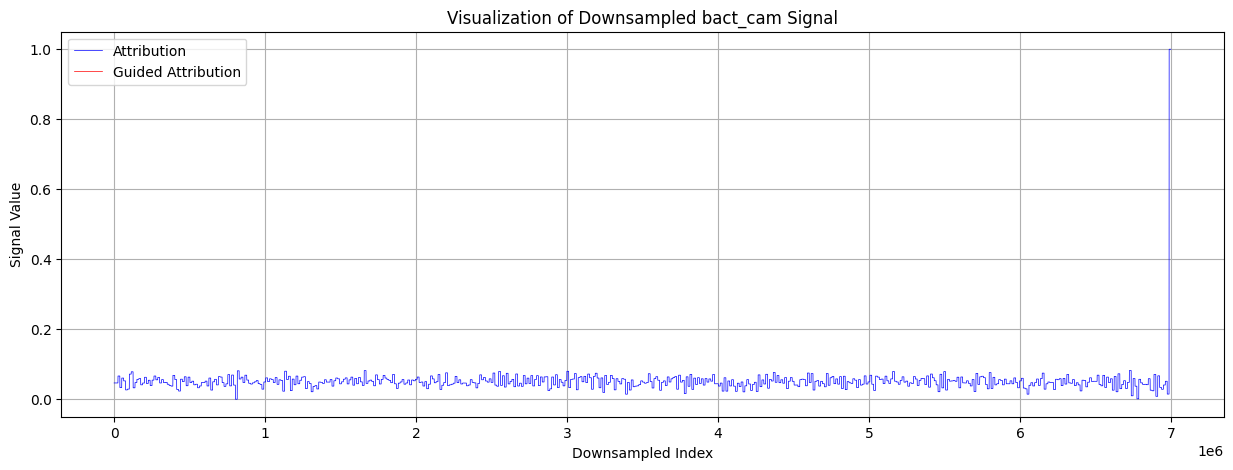

In [17]:
from scipy.signal import resample

import matplotlib.pyplot as plt

# Plot the downsampled signal
plt.figure(figsize=(15, 5))
plt.plot(attribution_scaled, lw=0.5, c='b')
plt.plot(attribution_guided_scaled, lw=0.5, c='r')
plt.title("Visualization of Downsampled bact_cam Signal")
plt.xlabel("Downsampled Index")
plt.ylabel("Signal Value")
plt.legend(["Attribution", "Guided Attribution"])
plt.grid(True)
plt.show()

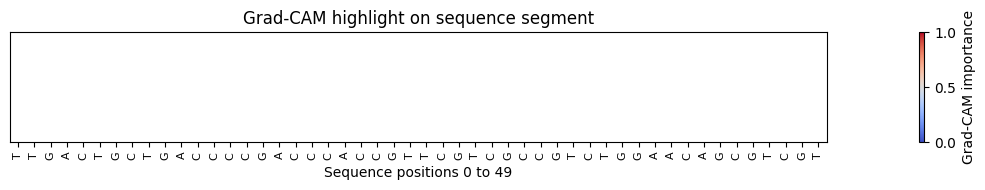

(<Figure size 1000x200 with 2 Axes>,
 <Axes: title={'center': 'Grad-CAM highlight on sequence segment'}, xlabel='Sequence positions 0 to 49'>)

In [18]:
plot_sequence_gradcam(bact_seq[:6988208], attribution_guided_scaled[:6988208])

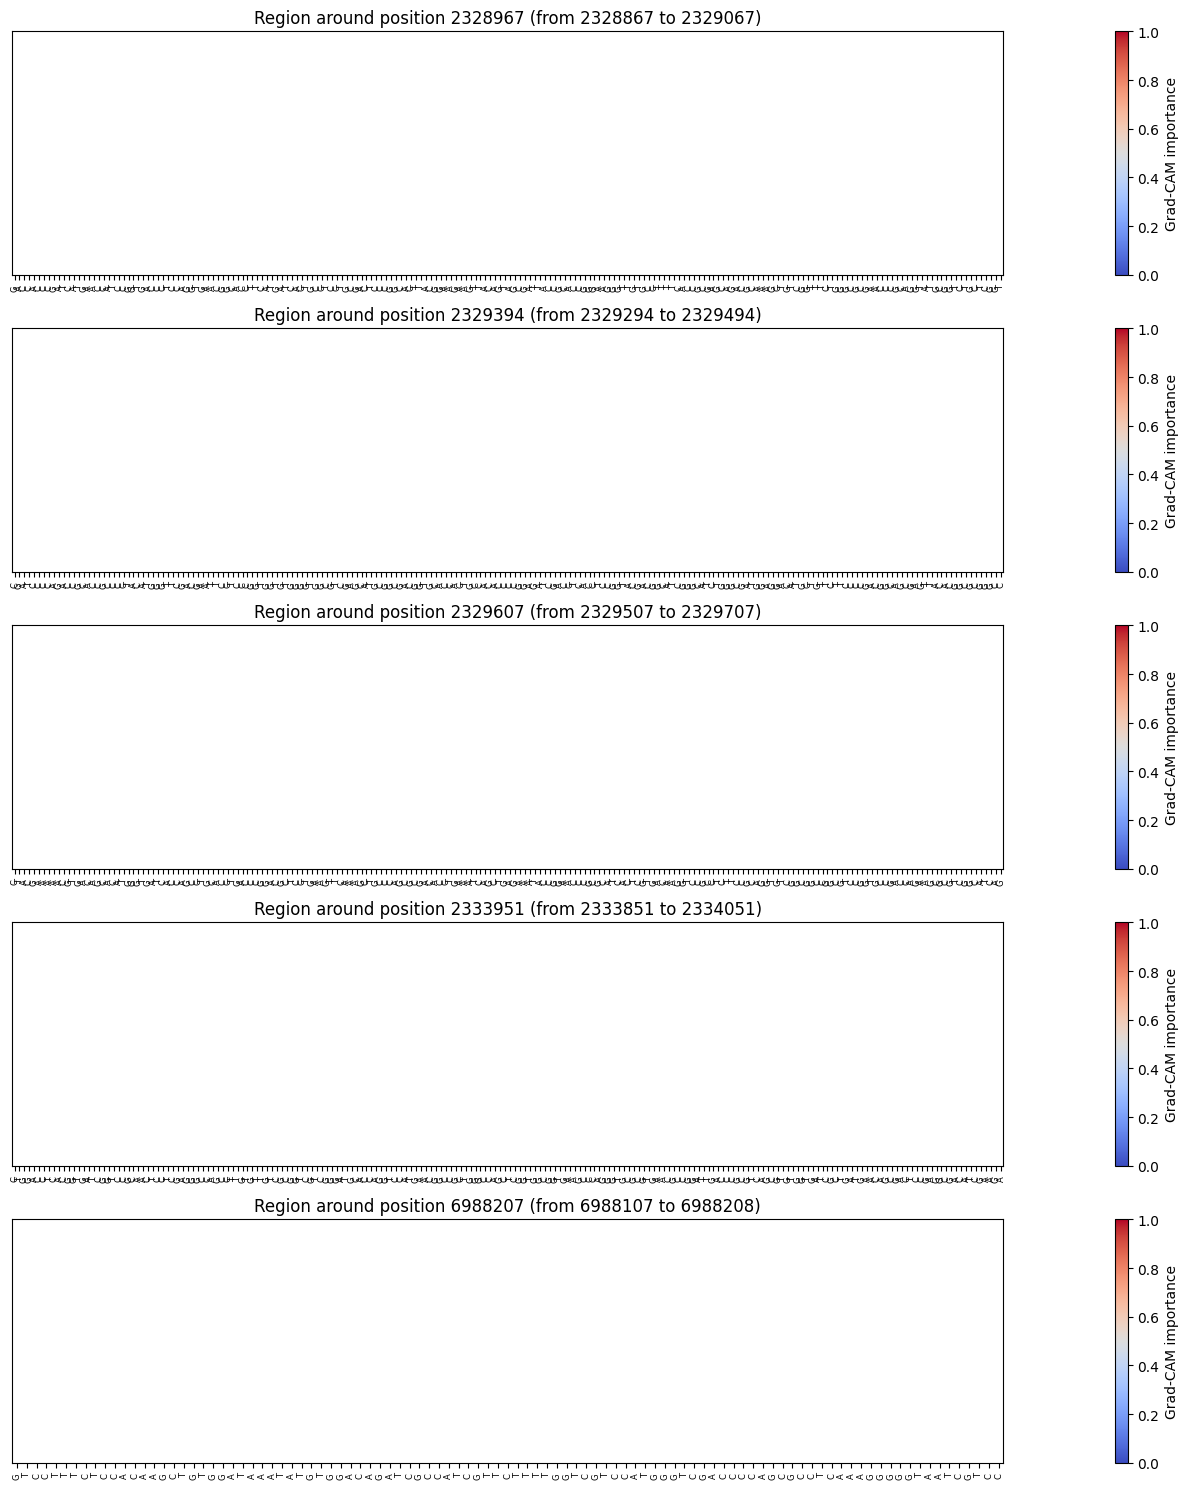

(<Figure size 1200x1500 with 10 Axes>,
 array([<Axes: title={'center': 'Region around position 2328967 (from 2328867 to 2329067)'}>,
        <Axes: title={'center': 'Region around position 2329394 (from 2329294 to 2329494)'}>,
        <Axes: title={'center': 'Region around position 2329607 (from 2329507 to 2329707)'}>,
        <Axes: title={'center': 'Region around position 2333951 (from 2333851 to 2334051)'}>,
        <Axes: title={'center': 'Region around position 6988207 (from 6988107 to 6988208)'}>],
       dtype=object))

In [19]:
plot_top_k_gradcam_regions(bact_seq[:6988208], attribution_guided_scaled[:6988208])

In [33]:
phages_df

,phage_id,phage_sequence,sequence_length
0,5326,TGCGGCCGCCCCATCCTGTACGGGTTTCCAAGTCGATCGGAGGGCA...,53124
1,6247,GGCTTTCGTGTGAGCCGTGATGTTTTCACGAATATGTGCCCCACCT...,74483
2,1976,GTGGGAATTTTTTTTTTGGGTTGCGCGGTGATCGCCGATGACGACG...,50781
3,430,ATGGCTTCGACTCAGACTCCAGCCGTCGGCAAGACCACGGCCATCG...,71565
4,431,TGCGGCTGAGCCATCGTGTACGGGTTTCCAAGTCCATCAGAGCCGG...,53396
...,...,...,...
3454,6189,TGCGGCTGCCAGATCGTGTACGGGTTTGGAAGTCGACGGAGAGAAC...,49487
3455,6190,ATGCTGGTCATGACCACAAACCACCGCCTCATCTACCTCGTCGGCG...,67744
3456,6191,TGCGGCCGAGGCATCGTGTACGGGTTTCCAAGCCCGAACTAACCAC...,52924
3457,6192,TGCAGATTTTGGTCTGTACGGAACCCGGGGGTTTCGCGGTTTCCCC...,56275


In [72]:
bacteria_df[bacteria_df['bacterium_sequence'].str[:1000] == bact_seq[:1000]]

,bacterium_id,bacterium_sequence,sequence_length
0,5859,TTGACTGCTGACCCCGACCCACCGTTCGTCGCCGTCTGGAACAGCG...,6988208


In [34]:
phages_df[phages_df['phage_sequence'].str[:13000] == phage_seq[:13000]]

,phage_id,phage_sequence,sequence_length
223,2154,GTCAGTTTTTTTTTCATACCGACGGAACGAAACCGGTAACTGATGA...,48639


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def find_top_k_important_windows(sequence, 
                                 combined_attribution, 
                                 k=5, 
                                 window_size=500):
    """
    Identify top k non-overlapping windows of fixed size based on mean Grad-CAM attribution.
    
    Parameters:
    -----------
    sequence : str
        The full DNA sequence (length N).
    combined_attribution : 1D np.array
        Grad-CAM attributions of length N.
    k : int
        Number of windows to retrieve.
    window_size : int
        Size of each window (bp).
    
    Returns:
    --------
    top_windows : list of tuples
        Each tuple contains (start_index, end_index, mean_attribution).
    """
    N = len(sequence)
    
    # Safety check
    if len(combined_attribution) != N:
        raise ValueError("Sequence and attribution must have the same length.")
    if window_size > N:
        raise ValueError("window_size cannot exceed the length of the sequence.")

    # 1. Compute mean attribution for each window using convolution
    # sums[i] will be sum of attributions in the window [i, i+window_size-1]
    # means will be sums / window_size
    sums = np.convolve(combined_attribution, np.ones(window_size, dtype=np.float32), mode='valid')
    means = sums / window_size  # shape: (N - window_size + 1,)

    # 2. Find indices that give the highest mean attribution
    # Sort window start indices by descending mean
    sorted_indices = np.argsort(means)[::-1]

    # 3. Pick top k non-overlapping windows
    selected_indices = []
    top_windows = []
    for idx in sorted_indices:
        # window range is [idx, idx + window_size)
        # check overlap with already selected windows
        overlap = False
        for (start_sel, end_sel, _) in top_windows:
            if not (idx + window_size <= start_sel or idx >= end_sel):
                # They overlap
                overlap = True
                break

        if not overlap:
            window_mean = means[idx]
            top_windows.append((idx, idx + window_size, window_mean))

        if len(top_windows) == k:
            break

    # Sort the final windows by their start index
    top_windows.sort(key=lambda x: x[0])
    return top_windows


def plot_top_windows(sequence, combined_attribution, top_windows):
    """
    Plot the attribution heatmaps for each selected window.

    Parameters:
    -----------
    sequence : str
        Full DNA sequence.
    combined_attribution : 1D np.array
        Grad-CAM attributions, length = len(sequence).
    top_windows : list of tuples
        (start, end, mean_val) for each window.
    """
    n = len(top_windows)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n))
    if n == 1:
        axs = [axs]  # ensure iterable

    for ax, (start, end, mean_val) in zip(axs, top_windows):
        region_seq = sequence[start:end]
        region_attr = combined_attribution[start:end]
        
        heatmap = region_attr[np.newaxis, :]  # shape (1, window_size)
        im = ax.imshow(heatmap, aspect='auto', cmap='coolwarm')
        
        ax.set_xticks(np.arange(len(region_seq)))
        ax.set_xticklabels(list(region_seq), fontsize=6, rotation=90)
        ax.set_yticks([])
        ax.set_title(f"Window {start}-{end}, Mean Attribution={mean_val:.4f}")
        
        # colorbar
        fig.colorbar(im, ax=ax, fraction=0.015, pad=0.1, label='Grad-CAM importance')

    plt.tight_layout()
    plt.show()
    return fig, axs


In [21]:
top_windows = find_top_k_important_windows(bact_seq, attribution_guided_scaled, 5, 500)

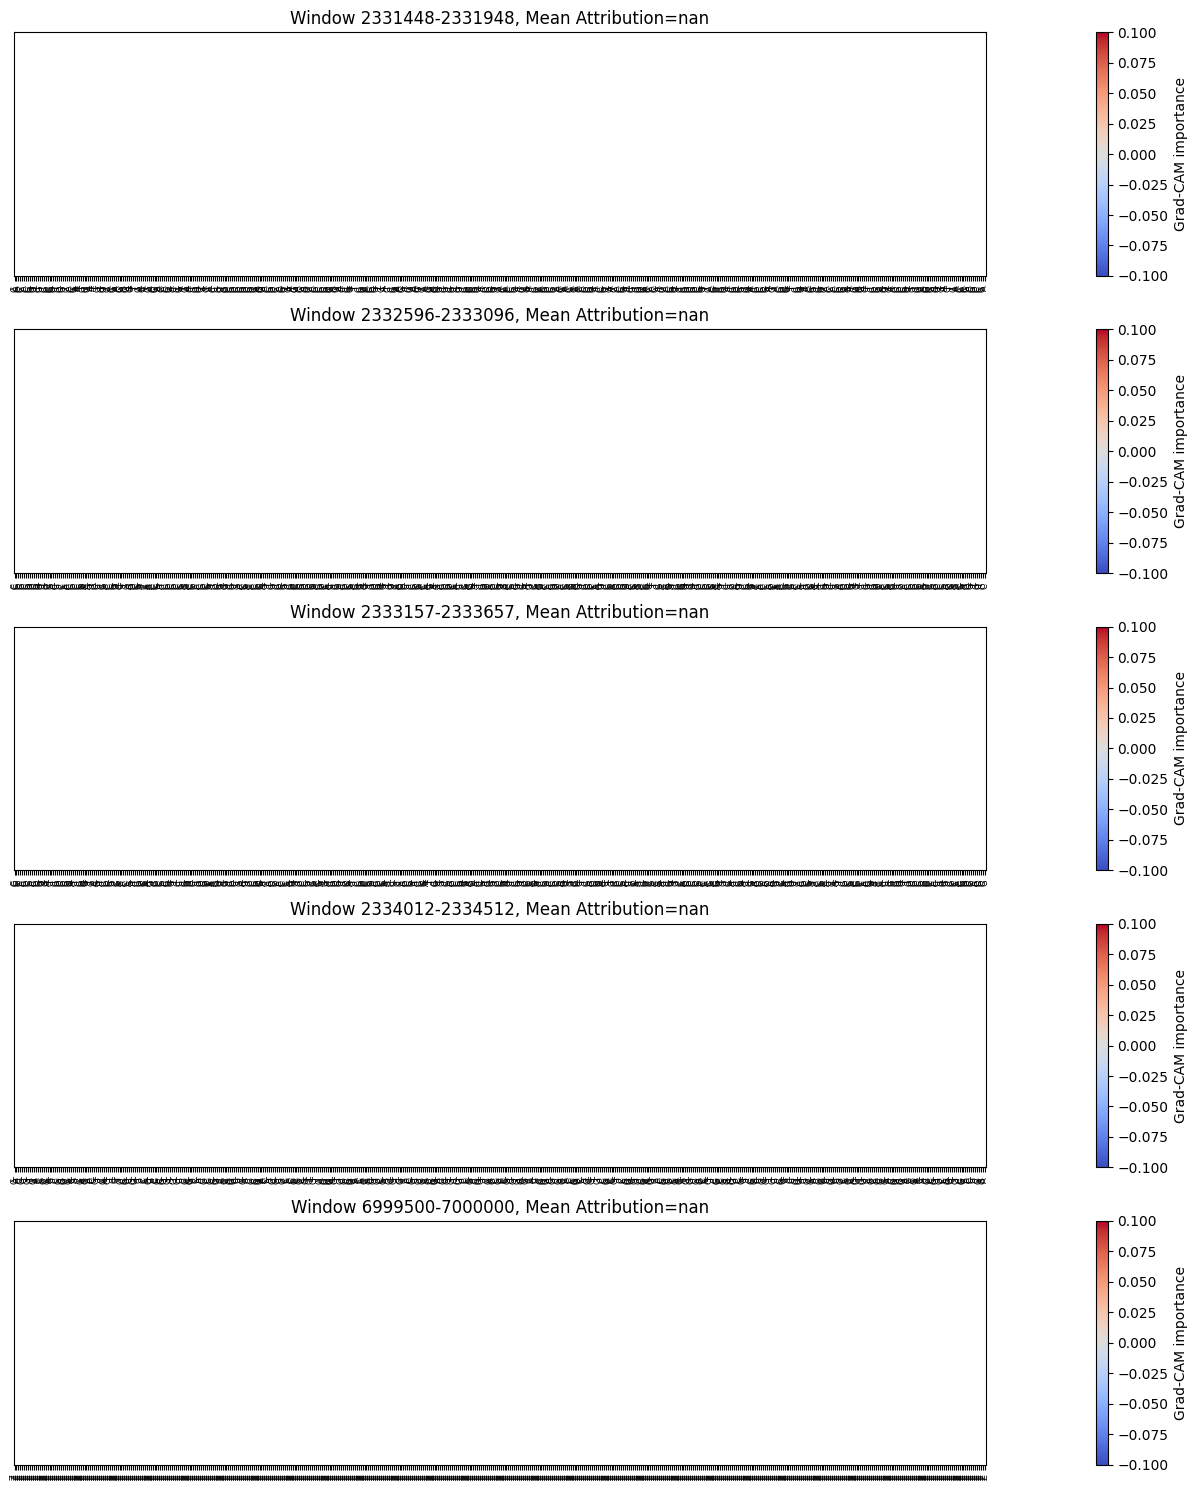

(<Figure size 1200x1500 with 10 Axes>,
 array([<Axes: title={'center': 'Window 2331448-2331948, Mean Attribution=nan'}>,
        <Axes: title={'center': 'Window 2332596-2333096, Mean Attribution=nan'}>,
        <Axes: title={'center': 'Window 2333157-2333657, Mean Attribution=nan'}>,
        <Axes: title={'center': 'Window 2334012-2334512, Mean Attribution=nan'}>,
        <Axes: title={'center': 'Window 6999500-7000000, Mean Attribution=nan'}>],
       dtype=object))

In [22]:
plot_top_windows(bact_seq, attribution_guided_scaled, top_windows)

In [89]:
window_start, window_end, mean_val = top_windows[1] 
subseq = bact_seq[window_start:window_end]


In [90]:
subseq

'CCTGGATGTAGCCCTGGTTGACCAGGCGCCGGTACGGCTCACGCGAGCTGACGTAACCCAGGTCGTAGAGCACCTTGTGCCAGAACCGCGAGTACAGCAGGTGCAGCACAGCGTGTTCCACGCCGCCGACGTACAGGTCGACACCGCCCGGATCCTCCGGGCCGTGCTCGTCGGGGCGCGGCCCCATCCAGTACGCCTCGTTCTCCTTGGCGCACATCTCATCCGGATTGTGCGGGTCGGTGTAGCGCAGCTCGTACCACGAGCTGCCGGCCCACTGCGGCATGACATTGGTGTCACGCGTGTAGGACTGCAGACCGTCACCGAGGTCGAGTTCGACGTGGACCCATTCGGTGGCCTTGTTCAGCGGCGGCGAGGGCTCGCTGTCGGCGTCGTCCGGGTCGAACAGCACCGGCGAGTAGTCGGGAACGTCCGGAAGCTCAACGGGCAGAGCAGATTCCGGCAGCGGGTGGGCACGTCCGTCGGCGTCGTAGACAATGGGG'

In [91]:
# Define a function to write this to a FASTA file
def write_fasta(seq, filename, seq_id="my_sequence"):
    with open(filename, "w") as f:
        f.write(f">{seq_id}\n")  # fasta header
        f.write(seq + "\n")       # actual sequence

write_fasta(subseq, "subseq2.fasta", seq_id="Seq1")
print("FASTA file created: subseq2.fasta")

FASTA file created: subseq2.fasta


In [93]:
from Bio import Entrez, SeqIO
from io import StringIO

Entrez.email = "arthur.babey@heig-vd.ch"  # REQUIRED for NCBI Entrez API

def fetch_genbank_features(accession, region_start=None, region_end=None):
    """
    Fetch GenBank features for a given accession and optional region.
    
    Parameters:
    - accession (str): NCBI accession ID (e.g., CP054795.1)
    - region_start (int): optional, start of region of interest
    - region_end (int): optional, end of region of interest
    
    Returns:
    - list of dicts: Each dict contains feature type, location, qualifiers
    """
    try:
        # Fetch full GenBank record
        handle = Entrez.efetch(db="nuccore", id=accession, rettype="gb", retmode="text")
        gb_text = handle.read()
        handle.close()

        record = SeqIO.read(StringIO(gb_text), "genbank")
        features = []

        for feature in record.features:
            # If region bounds provided, only return overlapping features
            if region_start and region_end:
                f_start = int(feature.location.start)
                f_end = int(feature.location.end)
                if f_end < region_start or f_start > region_end:
                    continue  # skip non-overlapping
            features.append({
                "type": feature.type,
                "location": f"{feature.location.start}..{feature.location.end}",
                "strand": feature.location.strand,
                "qualifiers": feature.qualifiers
            })

        return features

    except Exception as e:
        print(f"Error fetching GenBank for {accession}: {e}")
        return []


In [94]:
features = fetch_genbank_features("CP054795.1", region_start=5874204, region_end=5874703)
for feat in features:
    print(f"{feat['type']} at {feat['location']}")
    if "product" in feat["qualifiers"]:
        print(f"  ➤ product: {feat['qualifiers']['product'][0]}")
    if "gene" in feat["qualifiers"]:
        print(f"  ➤ gene: {feat['qualifiers']['gene'][0]}")


source at 0..6993871
gene at 5873394..5876256
CDS at 5873394..5876256
  ➤ product: leucine--tRNA ligase


In [95]:
features

[{'type': 'source',
  'location': '0..6993871',
  'strand': 1,
  'qualifiers': {'organism': ['Mycolicibacterium smegmatis'],
   'mol_type': ['genomic DNA'],
   'strain': ['FDAARGOS_679'],
   'culture_collection': ['ATCC:700084D-5'],
   'db_xref': ['taxon:1772'],
   'geo_loc_name': ['USA: VA'],
   'collected_by': ['ATCC']}},
 {'type': 'gene',
  'location': '5873394..5876256',
  'strand': -1,
  'qualifiers': {'locus_tag': ['FOB87_28340']}},
 {'type': 'CDS',
  'location': '5873394..5876256',
  'strand': -1,
  'qualifiers': {'locus_tag': ['FOB87_28340'],
   'EC_number': ['6.1.1.4'],
   'inference': ['COORDINATES: similar to AA sequence:RefSeq:WP_011731626.1'],
   'note': ['Derived by automated computational analysis using gene prediction method: Protein Homology.'],
   'codon_start': ['1'],
   'transl_table': ['11'],
   'product': ['leucine--tRNA ligase'],
   'protein_id': ['QKU05540.1'],
   'translation': ['MTEPATTPTTPDEQIPRHRYNADLAGQIERAWQETWSDRGTFNVANPVGSLAPTDGSDVPADKMFVQDMFPYPSGDGLHVGH

In [64]:
blast_summary = pd.read_csv('results_phage_222_20250403_164840/blast_features_summary.tsv', sep='\t')

In [74]:
blast_summary

,query_id,accession,region_start,region_end,feature_type,location,strand,gene,locus_tag,product,classification,organism
0,Seq1,MF133446.1,16087,16486,source,0..48639,1,NaN,NaN,NaN,coding,Mycobacterium phage Bogie
1,Seq1,MF133446.1,16087,16486,gene,14362..16108,1,17.0,SEA_BOGIE_17,NaN,coding,NaN
2,Seq1,MF133446.1,16087,16486,CDS,14362..16108,1,17.0,SEA_BOGIE_17,minor tail protein,coding,NaN
3,Seq1,MF133446.1,16087,16486,gene,16083..17844,1,18.0,SEA_BOGIE_18,NaN,coding,NaN
4,Seq1,MF133446.1,16087,16486,CDS,16083..17844,1,18.0,SEA_BOGIE_18,minor tail protein,coding,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
444,Seq3,MW055902.1,46355,46754,source,0..47149,1,NaN,NaN,NaN,coding,Mycobacterium phage Camster
445,Seq3,MW055902.1,46355,46754,gene,46304..46553,1,79.0,SEA_CAMSTER_79,NaN,coding,NaN
446,Seq3,MW055902.1,46355,46754,CDS,46304..46553,1,79.0,SEA_CAMSTER_79,hypothetical protein,coding,NaN
447,Seq3,MW055902.1,46355,46754,gene,46557..46941,1,80.0,SEA_CAMSTER_80,NaN,coding,NaN


In [73]:
blast_summary['organism'].value_counts()

organism
Mycobacterium phage Bogie             3
Mycobacterium phage Pygmy             3
Mycobacterium phage Shipwreck         3
Mycobacterium phage Techage           2
Mycobacterium phage FirstPlacePfu     2
Mycobacterium phage StressBall        2
Mycobacterium phage Bartholomew       2
Mycobacterium phage Sonah             2
Mycobacterium phage juyeon            2
Mycobacterium phage LOCV5             2
Mycobacterium phage LOCV4             2
Mycobacterium phage LOCV3             2
Mycobacterium phage LOCV1             2
Mycobacterium phage Dynamo            2
Mycobacterium phage Langerak          2
Mycobacterium phage Venti             2
Mycobacterium phage Donovan           2
Mycobacterium phage Fishburne         2
Mycobacterium phage Camster           2
Mycobacterium phage Jebeks            2
Mycobacterium phage Necropolis        2
Mycobacterium phage Phineas           2
Mycobacterium phage Zilizebeth        2
Mycobacterium phage HUHilltop         2
Mycobacterium phage Thespis    

In [75]:
def extract_cds_features(df):
    # Get organism per accession from the 'source' row
    organism_map = df[df['feature_type'] == 'source'].set_index('accession')['organism'].to_dict()

    # Filter only CDS rows
    cds_df = df[df['feature_type'] == 'CDS'].copy()

    # Assign organism to each CDS based on accession
    cds_df['organism'] = cds_df['accession'].map(organism_map)

    # Select and reorder relevant columns
    return cds_df[[
        'accession',
        'region_start',
        'region_end',
        'gene',
        'locus_tag',
        'product',
        'organism'
    ]].reset_index(drop=True)


compressed_df = extract_cds_features(blast_summary)



In [79]:
compressed_df[compressed_df['product'] == 'hypothetical protein'].head(10)

,accession,region_start,region_end,gene,locus_tag,product,organism
86,PP758913.1,24120,24519,26.0,SEA_PYGMY_26,hypothetical protein,Mycobacterium phage Pygmy
87,MF133446.1,24120,24519,26.0,SEA_BOGIE_26,hypothetical protein,Mycobacterium phage Bogie
88,NC_031261.1,24098,24497,26.0,SEA_SHIPWRECK_26,hypothetical protein,Mycobacterium phage Shipwreck
89,HM152765.1,24475,24874,27.0,ISLAND3_27,hypothetical protein,Mycobacterium phage Island3
91,MN010757.1,46102,46501,80.0,SEA_HUHILLTOP_80,hypothetical protein,Mycobacterium phage HUHilltop
93,NC_051731.1,47630,48029,79.0,I5J42_gp79,hypothetical protein,Mycobacterium phage GreaseLightnin
95,MK016499.1,46817,47216,80.0,PBI_MANGETHE_80,hypothetical protein,Mycobacterium phage Mangethe
97,PP758913.1,47818,48217,81.0,SEA_PYGMY_81,hypothetical protein,Mycobacterium phage Pygmy
99,NC_051736.1,45938,46337,NaN,I5J47_gp77,hypothetical protein,Mycobacterium phage Arib1
101,NC_051737.1,46817,47216,80.0,I5J48_gp80,hypothetical protein,Mycobacterium phage Majeke


In [77]:
compressed_df['product'].value_counts()

product
minor tail protein                    86
hypothetical protein                  52
HNH endonuclease                      47
gp27                                   1
Flg_hook domain-containing protein     1
Name: count, dtype: int64

In [78]:
compressed_df['organism'].value_counts()

organism
Mycobacterium phage Bogie             5
Mycobacterium phage Pygmy             5
Mycobacterium phage Shipwreck         5
Mycobacterium phage LOCV3             4
Mycobacterium phage StressBall        4
Mycobacterium phage Bartholomew       4
Mycobacterium phage Sonah             4
Mycobacterium phage juyeon            4
Mycobacterium phage LOCV5             4
Mycobacterium phage LOCV4             4
Mycobacterium phage LOCV1             4
Mycobacterium phage Techage           4
Mycobacterium phage Dynamo            4
Mycobacterium phage Langerak          4
Mycobacterium phage Venti             4
Mycobacterium phage Donovan           4
Mycobacterium phage Fishburne         4
Mycobacterium phage Camster           4
Mycobacterium phage Jebeks            4
Mycobacterium phage Necropolis        4
Mycobacterium phage FirstPlacePfu     4
Mycobacterium phage Zilizebeth        4
Mycobacterium phage HUHilltop         4
Mycobacterium phage Ksquared          4
Mycobacterium phage KilKor     

In [61]:
blast_summary_gene['product'].value_counts()

product
minor tail protein                    86
hypothetical protein                  52
HNH endonuclease                      47
gp27                                   1
Flg_hook domain-containing protein     1
Name: count, dtype: int64

In [35]:
def fetch_genbank_features(accession, region_start=None, region_end=None):
    """
    Fetch GenBank features for a given accession and optional region.
    Returns a list of features overlapping the region.
    """
    try:
        handle = Entrez.efetch(db="nuccore", id=accession, rettype="gb", retmode="text")
        gb_text = handle.read()
        handle.close()
        record = SeqIO.read(StringIO(gb_text), "genbank")
    except Exception as e:
        print(f"Error fetching GenBank record for {accession}: {e}")
        return []

    features = []
    for feature in record.features:
        if region_start is not None and region_end is not None:
            f_start = int(feature.location.start)
            f_end = int(feature.location.end)
            if f_end < region_start or f_start > region_end:
                continue  # skip non-overlapping
        features.append({
            "type": feature.type,
            "location": f"{int(feature.location.start)}..{int(feature.location.end)}",
            "strand": feature.location.strand,
            "qualifiers": feature.qualifiers
        })
    return features


In [41]:
fetch_genbank_features('MF133446.1', 16087, 16486)

[{'type': 'source',
  'location': '0..48639',
  'strand': 1,
  'qualifiers': {'organism': ['Mycobacterium phage Bogie'],
   'mol_type': ['genomic DNA'],
   'isolation_source': ['soil'],
   'db_xref': ['taxon:2014350'],
   'lab_host': ['Mycobacterium smegmatis mc2 155'],
   'geo_loc_name': ['USA: Camden, AR'],
   'lat_lon': ['33.4700 N 92.8734 W'],
   'collection_date': ['01-Oct-2015'],
   'collected_by': ['R. Rogers'],
   'identified_by': ['R. Rogers, C. Morris']}},
 {'type': 'gene',
  'location': '14362..16108',
  'strand': 1,
  'qualifiers': {'gene': ['17'], 'locus_tag': ['SEA_BOGIE_17']}},
 {'type': 'CDS',
  'location': '14362..16108',
  'strand': 1,
  'qualifiers': {'gene': ['17'],
   'locus_tag': ['SEA_BOGIE_17'],
   'codon_start': ['1'],
   'transl_table': ['11'],
   'product': ['minor tail protein'],
   'protein_id': ['ASD53647.1'],
   'translation': ['MTQDKQTFPPGEATLLGQELMLERTDPLIMLTTADRKVTFYLSGGLAAWPRHQDGVNLVEITTPTPEFRNLRAQGARQDGGQTRDTVYDPMQIDAVFLASATTPDGLSRVVSEWIAANDPEQLCRLEW

In [40]:
from io import StringIO
from Bio import Entrez, SeqIO